In [1]:
import os
import gc
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
from contextlib import contextmanager
import time

import numpy as np
import pandas as pd
import scipy as sp
import random

import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn import preprocessing
import category_encoders as ce
from sklearn.metrics import mean_squared_error

import torch
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
np.random.seed(0)

from pytorch_tabnet.tab_model import TabNetRegressor ##Import Tabnet 
from sklearn.model_selection import ParameterGrid
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import os
from pathlib import Path
import os.path as osp

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
data_path = osp.join(os.getcwd(),'Data')
df = pd.read_csv(data_path + '/model.csv')
df = df.drop(['Date','News','Unnamed: 0'],axis=1)

In [3]:
df.head()

,cap,stochaistic_k_percent,stochaistic_D,Momentum,rate_of_change,William_R_percent,AD_oscillator,Disparity
0,297.580078,93.106137,13.300877,0.000000,8649.194013,0.068939,0.068939,100.000000
1,52.030273,82.307244,25.059054,48.029297,24531.588728,0.176928,0.693131,100.204235
2,-148.890625,53.109049,32.646061,-91.850585,-12675.444285,0.468910,0.000000,99.340910
3,-100.739258,30.250241,36.967524,-201.360351,-5727.522774,0.697498,-0.048157,98.800097
4,79.139649,47.569144,43.763116,-118.390624,-9811.528393,0.524309,0.693070,99.608320


In [4]:
scalar = StandardScaler()
scaled_features = scalar.fit_transform(df.values)

In [5]:
train = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

In [6]:
target = 'cap'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.9, .05, .05], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [7]:
for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

In [8]:
unused_feat = ['Set']
features = [ col for col in train.columns if col not in unused_feat+[target]] 

In [9]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

In [10]:
#from model evaluation best hyper parametrs are selected for tabnet regressor
tabnet_rg = TabNetRegressor(clip_value = 2,
                            gamma = 2,
                            lambda_sparse = 0.0001,
                            momentum =0.3,
                            n_a=24,
                            n_d=24,
                            n_independent = 2,
                            n_shared=2,
                            n_steps=3 )

Device used : cuda


In [11]:
import os
max_epochs = 25 if not os.getenv("CI", False) else 2

In [12]:
tabnet_rg.fit(
    X_train=X_train, y_train=y_train, 
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=max_epochs,
    patience=7,
    batch_size=128, 
    num_workers=4,
    drop_last=False
)

Will train until validation stopping metric hasn't improved in 7 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | -1.09781 |  -0.77340 |   8.4       
| 2     | -0.62821 |  -0.39373 |   14.1      
| 3     | -0.54271 |  -0.29938 |   19.9      
| 4     | -0.49170 |  -0.41588 |   25.6      
| 5     | -0.44568 |  -0.50937 |   31.2      
| 6     | -0.43232 |  -0.37989 |   36.7      
| 7     | -0.43537 |  -0.46190 |   43.2      
| 8     | -0.42650 |  -0.37708 |   49.2      
| 9     | -0.40018 |  -0.29872 |   54.7      
| 10    | -0.41455 |  -0.31331 |   60.2      
| 11    | -0.44231 |  -0.32354 |   65.8      
| 12    | -0.39961 |  -0.32614 |   71.3      
| 13    | -0.41085 |  -0.33799 |   76.8      
| 14    | -0.40555 |  -0.28822 |   82.5      
| 15    | -0.40277 |  -0.30068 |   88.2      
| 16    | -0.39962 |  -0.34724 |   93.7      
| 17    | -0.41139 |  -0.33826 |   99.2      
| 18    | -0.38247 |  -0.39993 |   104.8     
| 19    | -0.

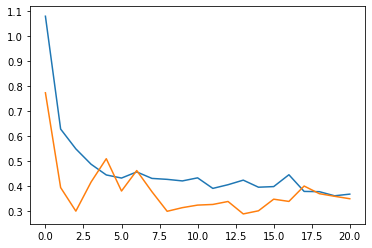

In [13]:
# plot losses
plt.plot(tabnet_rg.history['train']['loss'])
plt.plot(tabnet_rg.history['valid']['loss'])

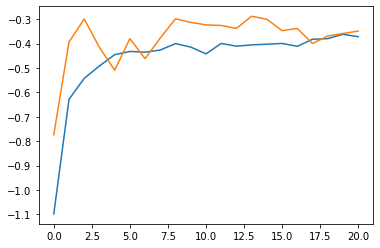

In [14]:
# plot accuracies
plt.plot([-x for x in tabnet_rg.history['train']['metric']])
plt.plot([-x for x in tabnet_rg.history['valid']['metric']])

In [15]:
y_pred = tabnet_rg.predict(X_test)    
t_rmse = mse(y_test, y_pred,squared=False)    
t_mae = mae(y_test, y_pred)

In [16]:
t_rmse,t_mae

(0.6549360260338464, 0.3349110300856572)

In [17]:
datapoints = [i for i in range(0,len(y_test))]
main_df = pd.DataFrame.from_dict({'days':datapoints,'test values' :y_test.flatten(),'predicted values' : y_pred.flatten() })

<Figure size 1152x864 with 0 Axes>

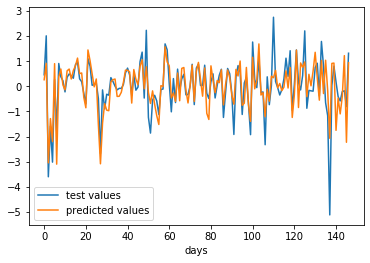

In [18]:
plt.figure().set_size_inches(16,12)
main_df.plot(label='test values',y='test values',x='days')
main_df['predicted values'].plot(label='predicted values')

plt.legend()

In [19]:
model_path = osp.join(os.getcwd(),'Models')
torch.save(tabnet_rg, model_path + '/tabnet.pt')

In [20]:
from pickle import dump
dump(scalar, open(model_path + '/tabnet-scaler.pkl', 'wb'))